# Final Project Capstone - Battle of Neighbourhoods

## Chinese Restaurants in New York

### 1.Introduction

New York is one of the largest city in the North America and the most populated city in the United States. New York City is a metropolitan area with more than 8 million people , having also the largest Chinese population (around 1 million people) of any city outside of Asia and within the USA.
With more than 2000 chinese restaurants in New York City ,the competition is very high.
The chinese cuisine is on top food interests in New York not only for residents but also for tourists.
This final project will try to answer to the next questions: 
-Which neigborhoods have the best chinese restaurants?
-Which is the best chinese restaurant in New York(Tips,Likes,Rating)?
-Which areas are best for living if one prefers chinese cuisine?

### 2.Data

The data used for this project is gathered from different sources:
  - an unprocessed New York data was downloaded in JSON data format:https://cocl.us/new_york_dataset containing neighborhoods and boroughs, latitudes, and longitudes;
  - Foursquare API as location data provider, used to retrieve data about chinese restaurants in different neighborhoods, ratings, tips: https://developer.foursquare.com/docs


        


###  3.Methodology

We followed the next steps:

- import New York City Data containing list of Boroughs,Neighbourhoods along with their latitude and longitude from https://cocl.us/new_york_dataset.
- based on latitude and longitude, we are searching for restaurants for each Neighborhood via Foursquare API.
- filter out only Chinese Restaurants.
- retrieve information like: Ratings, Likes, Tips for each Chinese Restaurant, again by using Foursquare API.
- analyze data obtained
- Visualize the conclusions on the map of New York.

###  4.Code

Download all the dependencies.

In [1]:
import numpy as np # library to handle data in a vectorized manner
!pip install folium
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Libraries imported.


***Download New York City Dataset***

For segmenting the neighborhoods of New York, a dataset is required that contains the 5 boroughs and the neighborhoods, that exist in each borough, with their latitude and longitude coordinates.

This dataset is available in json format file: https://cocl.us/new_york_dataset/newyork_data.json

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]


Data downloaded!


{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

***Tranform the data into a pandas dataframe***

The next step is transforming this data of nested Python dictionaries into a pandas dataframe.

In [3]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)



Then loop through the data and fill the dataframe one row at a time.

In [4]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)


Quickly examine the resulting dataframe.

In [5]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


***Plot the Number of Neighborhoods per Borough in New York***

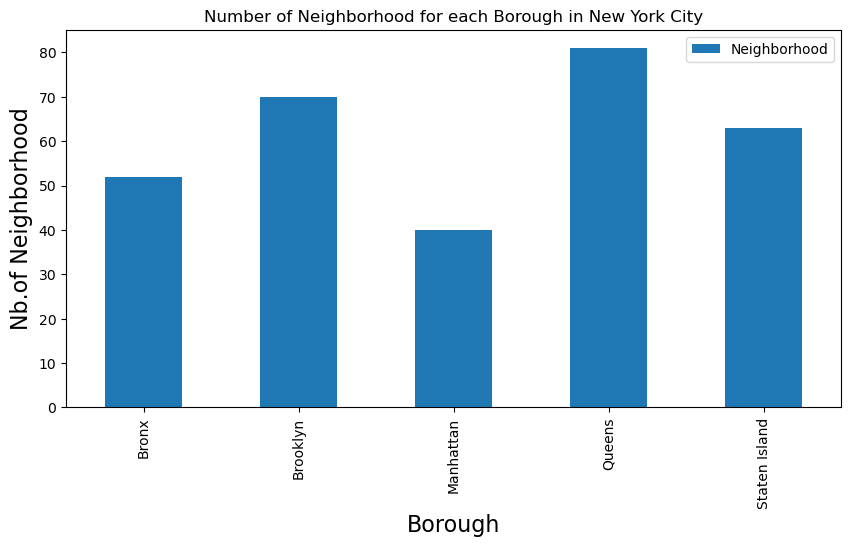

In [6]:
plt.figure(figsize=(10,5), dpi = 100)
plt.title('Number of Neighborhood for each Borough in New York City')
plt.xlabel('Borough', fontsize = 16)
plt.ylabel('Nb.of Neighborhood', fontsize=16)
neighborhoods.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
plt.legend()
plt.show()

***Define Foursquare Credentials and Version***

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

In [7]:
CLIENT_ID = '55BJQJT3CU15FPS2PWZOFF2ODL2T5M0M430AKTNM2AJZLTQN' 
CLIENT_SECRET = 'SKC0Z52R4LP1HBAJTG1WG53MCZCX4FVRW5X1IUGTJZB4WXE4' 
VERSION = '20180605' 
LIMIT = 450
radius=500

***Define a function for retrieving latitude and longitude for address='New York'*** 

In [65]:
def get_location(address):
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude
get_location('New York')

(40.7127281, -74.0060152)

***Define a function for retrieving venues for a specific latitude and longitude***

In [9]:
def get_venues(latitude, longitude):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID,CLIENT_SECRET,VERSION,latitude,longitude,radius,LIMIT)
    results = requests.get(url).json()
    venue_data = results['response']['groups'][0]['items']
    venues_list = []
    for venue in venue_data:
        venue_id = venue['venue']['id']
        venue_name = venue['venue']['name']
        venue_category = venue['venue']['categories'][0]['name']
        venues_list.append([venue_id, venue_name, venue_category])
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venues_list, columns = column_names)
    return df

***Retrieve venues for each Neighborhood only for chinese restaurants***

In [10]:
chinese_rest = pd.DataFrame(columns = ['Borough', 'Neighborhood', 'ID', 'Name'])
for row in neighborhoods.values.tolist():
    Borough, Neighborhood, latitude, longitude = row
    latitude=str(latitude)
    longitude=str(longitude)
    venues = get_venues(latitude, longitude)
    venues1 = venues[venues['Category'] == 'Chinese Restaurant']
    for restaurant_detail in venues1.values.tolist():
        id, name , category = restaurant_detail
        chinese_rest = chinese_rest.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)

In [11]:
chinese_rest.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Eastchester,4dabc3dc93a04642f09ccabd,Xing Lung Chinese Restaurant
1,Bronx,Norwood,4e41d2c4b61ca5ba3b1f9c6b,Ming Liang Kitchen
2,Bronx,Norwood,4ce313fc438b224bbc6c80a3,Happy Dragon
3,Bronx,Pelham Parkway,4b9d6b45f964a52078ab36e3,Mr. Q's Chinese Restaurant
4,Bronx,Bedford Park,4e4d0387bd413c4cc66dfd72,Hung Hing Chinese Restaurant


In [12]:
chinese_rest.shape

(220, 4)

***The number of chinese restaurants is 220 in New York City for a radius of 500***

In [13]:
# Save the data in a csv file since a larger number of calls is limited
chinese_rest.to_csv('chinese_rest.csv', index=False)
chinese_rest_csv = pd.read_csv('chinese_rest.csv')

***Define a function for getting  rating ,tip counts for a given restaurant id***

In [16]:
def get_restaurant_details(restaurant_id): 
    CLIENT_ID = 'GOTX3LWU1OH25XHTOOVLBY5QXLI0CVC0NOE35RB5V3IGUYU5'
    CLIENT_SECRET = 'PLLJLNX2GYE2RIFMIQR3NREGLRZRCSDN42COWBASNPUJ5PDP'
    VERSION = '20180605' # Foursquare API version
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            restaurant_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    restaurant_data=results['response']['venue']
    restaurant_info=[]
    try:
        restaurant_id=restaurant_data['id']
        restaurant_name=restaurant_data['name']
        restaurant_likes=restaurant_data['likes']['count']
        restaurant_rating=restaurant_data['rating']
        restaurant_tips=restaurant_data['tips']['count']
        restaurant_info.append([restaurant_id,restaurant_name,restaurant_likes,restaurant_rating,restaurant_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(restaurant_info,columns=column_names)
    return df

In [17]:
# prepare neighborhood list that contains chinese restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
chinese_rest_stats=pd.DataFrame(columns=column_names)
count=1

for row in chinese_rest.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        restaurant_details=get_restaurant_details(ID)
        print(restaurant_details)
        id,name,likes,rating,tips=restaurant_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    chinese_rest_stats = chinese_rest_stats.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID                          Name  Likes  Rating  Tips
0  4dabc3dc93a04642f09ccabd  Xing Lung Chinese Restaurant      6     6.7     0
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4e41d2c4b61ca5ba3b1f9c6b
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4ce313fc438b224bbc6c80a3
                         ID                        Name  Likes  Rating  Tips
0  4b9d6b45f964a52078ab36e3  Mr. Q's Chinese Restaurant     10     7.6    10
                         ID                          Name  Likes  Rating  Tips
0  4e4d0387bd413c4cc66dfd72  Hung Hing Chinese Restaurant      5     6.4     2
                         ID                            Name  Likes  Rating  \
0  4e2e08021838f1c552b6b8eb  Choi Yuan - Chinese Restaurant      6     6.3   

   Tips  
0     8  
                         ID           Name  Likes  Rating  Tips
0  566f33e7498e44c2501bda81  Panda Express     12    

In [18]:
chinese_rest_stats.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Eastchester,4dabc3dc93a04642f09ccabd,Xing Lung Chinese Restaurant,6,6.7,0
1,Bronx,Norwood,0,0,0,0.0,0
2,Bronx,Norwood,0,0,0,0.0,0
3,Bronx,Pelham Parkway,4b9d6b45f964a52078ab36e3,Mr. Q's Chinese Restaurant,10,7.6,10
4,Bronx,Bedford Park,4e4d0387bd413c4cc66dfd72,Hung Hing Chinese Restaurant,5,6.4,2


In [19]:
chinese_rest_stats.shape

(220, 7)

So from 220 total number of restaurants all of them have Likes,rating and tips

Now that we got data for all Chinese Restaurants, lets save this data to a csv sheet. In case we by mistake modify it.

In [20]:
# Save the data in a csv file
chinese_rest_stats.to_csv('chinese_rest_stats.csv', index=False)
chinese_rest_stats_csv = pd.read_csv('chinese_rest_stats.csv')
chinese_rest_stats_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Eastchester,4dabc3dc93a04642f09ccabd,Xing Lung Chinese Restaurant,6,6.7,0
1,Bronx,Norwood,0,0,0,0.0,0
2,Bronx,Norwood,0,0,0,0.0,0
3,Bronx,Pelham Parkway,4b9d6b45f964a52078ab36e3,Mr. Q's Chinese Restaurant,10,7.6,10
4,Bronx,Bedford Park,4e4d0387bd413c4cc66dfd72,Hung Hing Chinese Restaurant,5,6.4,2


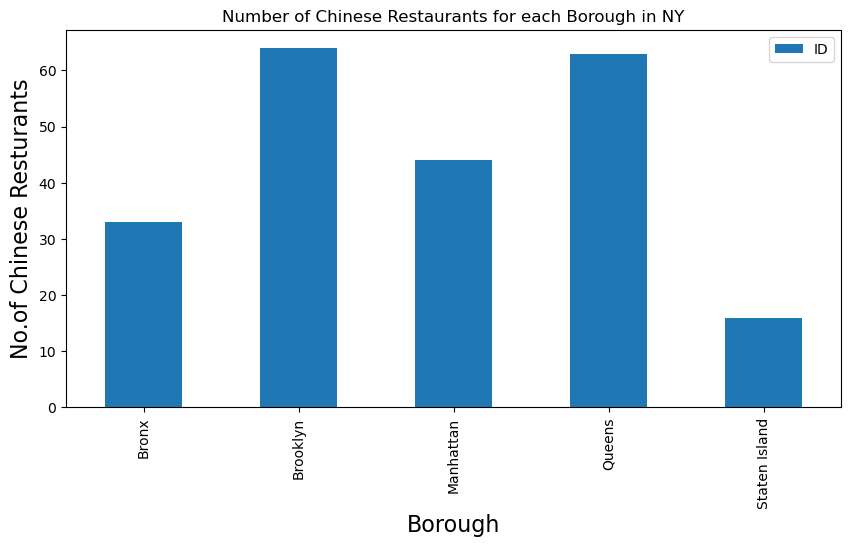

In [25]:
plt.figure(figsize=(10,5), dpi = 100)
plt.title('Number of Chinese Restaurants for each Borough in NY')
plt.xlabel('Borough', fontsize = 16)
plt.ylabel('No.of Chinese Resturants', fontsize=16)
chinese_rest_stats.groupby('Borough')['ID'].count().plot(kind='bar')
plt.legend()
plt.show()

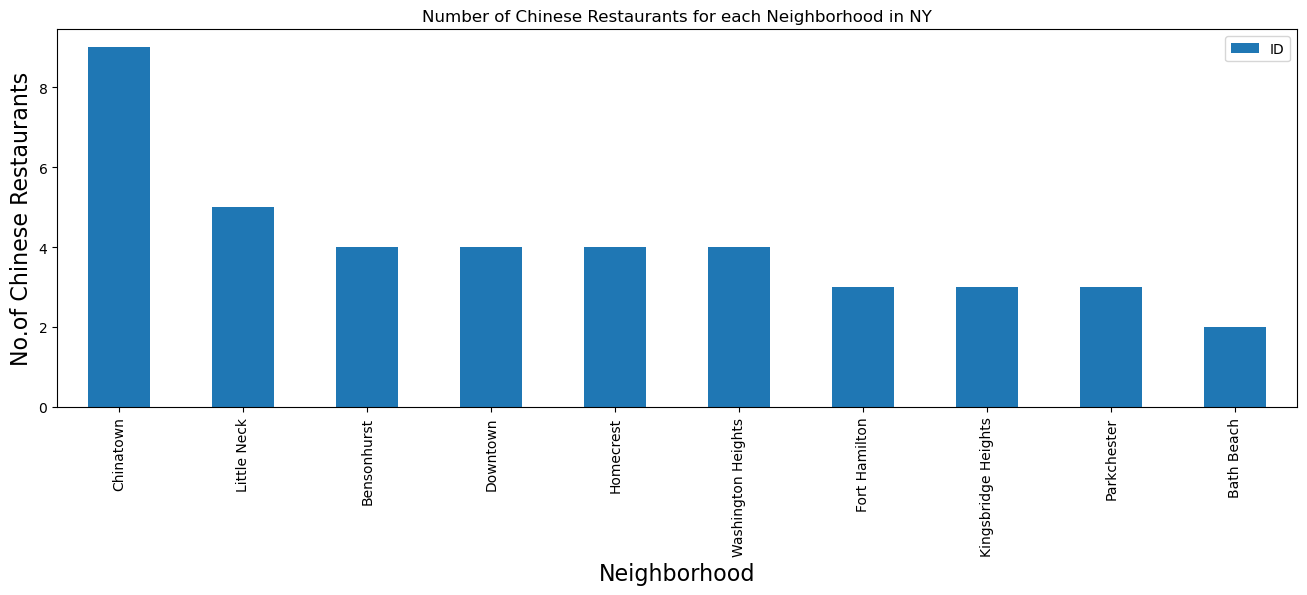

In [22]:
plt.figure(figsize=(16,5), dpi = 100)
plt.title('Number of Chinese Restaurants for each Neighborhood in NY')
plt.xlabel('Neighborhood', fontsize = 16)
plt.ylabel('No.of Chinese Restaurants', fontsize=16)
chinese_rest.groupby('Neighborhood')['ID'].count().nlargest(10).plot(kind='bar')
plt.legend()
plt.show()

From the last 2 plots we can see that Borough with the largest number of of chinese restaurants is Brooklyn and Neighborhood with the largest number of chinese restaurants is Chinatown.

In [42]:
chinese_rest_csv.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Eastchester,4dabc3dc93a04642f09ccabd,Xing Lung Chinese Restaurant
1,Bronx,Norwood,4e41d2c4b61ca5ba3b1f9c6b,Ming Liang Kitchen
2,Bronx,Norwood,4ce313fc438b224bbc6c80a3,Happy Dragon
3,Bronx,Pelham Parkway,4b9d6b45f964a52078ab36e3,Mr. Q's Chinese Restaurant
4,Bronx,Bedford Park,4e4d0387bd413c4cc66dfd72,Hung Hing Chinese Restaurant


In [43]:
# merging chinese_rest_stats_csv with chinese_rest_csv dataframe to get Borough,neighborhood,ID,Likes,Rating,Tips for each restaurant
rests_stats1 = pd.merge(chinese_rest_stats_csv , chinese_rest_csv)
rests_stats1.drop_duplicates(inplace = True)
rests_stats1.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Eastchester,4dabc3dc93a04642f09ccabd,Xing Lung Chinese Restaurant,6,6.7,0
1,Bronx,Pelham Parkway,4b9d6b45f964a52078ab36e3,Mr. Q's Chinese Restaurant,10,7.6,10
2,Bronx,Bedford Park,4e4d0387bd413c4cc66dfd72,Hung Hing Chinese Restaurant,5,6.4,2
3,Bronx,Bedford Park,4e2e08021838f1c552b6b8eb,Choi Yuan - Chinese Restaurant,6,6.3,8
4,Bronx,Fordham,566f33e7498e44c2501bda81,Panda Express,12,7.7,2


***Now we will find the Chinese restaurants with Maximum Likes.***

In [44]:
# Restaurant with maximum likes
rests_stats1.loc[rests_stats1['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1491
Rating                               9.2
Tips                                 522
Name: 62, dtype: object

***Now we will find the Chinese restaurants with Maximum Tips.***

In [45]:
# Restaurant with maximum tips
rests_stats1.loc[rests_stats1['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1491
Rating                               9.2
Tips                                 522
Name: 62, dtype: object

***Now we will find the Chinese restaurants with Maximum Ratings***

In [51]:
# Restaurant with maximum rating
rests_stats1.loc[rests_stats1['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1491
Rating                               9.2
Tips                                 522
Name: 62, dtype: object

***Calculating Average Rating for each Neighborhood***

In [53]:
neighborhood_stats = rests_stats1.groupby('Neighborhood',as_index=False).mean()[['Neighborhood', 'Rating']]
neighborhood_stats.columns = ['Neighborhood', 'Average Rating']
neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
13,Chelsea,9.200000
28,Flatiron,9.100000
24,East Village,9.000000
76,Windsor Terrace,9.000000
75,West Village,8.950000
72,Upper West Side,8.800000
54,Murray Hill,8.800000
46,Little Italy,8.666667
65,Soho,8.600000
14,Chinatown,8.462500


***Calculating Average Rating for each Borough***

In [54]:
neighborhood_stats=rests_stats1.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
neighborhood_stats.columns=['Borough','Average Rating']
neighborhood_stats.sort_values(['Average Rating'],ascending=False)

,Borough,Average Rating
2,Manhattan,8.054762
3,Queens,7.157143
1,Brooklyn,7.088889
4,Staten Island,6.940000
0,Bronx,6.753846


***Bar plot of Average Rating of Chinese Restaurants for each Borough***

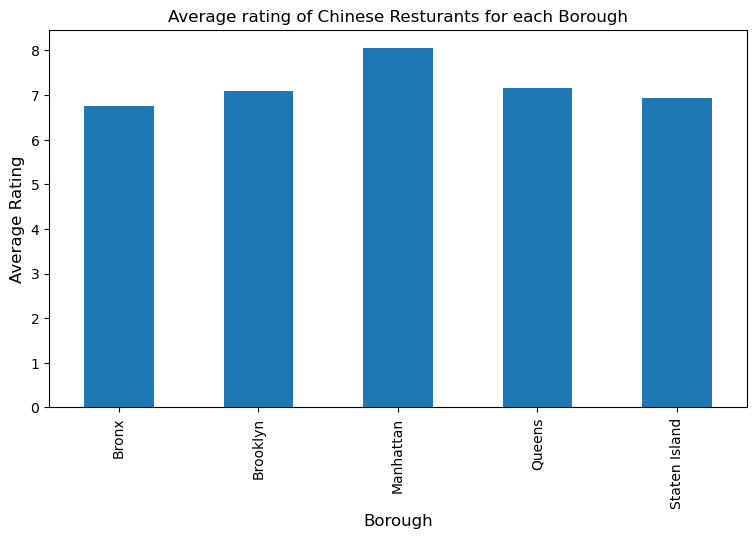

In [57]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Chinese Resturants for each Borough')
plt.xlabel('Borough', fontsize = 12)
plt.ylabel('Average Rating', fontsize=12)
rests_stats1.groupby('Borough').mean()['Rating'].plot(kind='bar')
plt.show()

***Selecting Neighborhoods whose Average Rating is >= 8 to visualize on map***

In [58]:
neighborhood_stats1=neighborhood_stats[neighborhood_stats['Average Rating']>=8.0]
neighborhood_stats1

,Borough,Average Rating
2,Manhattan,8.054762


In [60]:
neighborhood_stats1 = pd.merge(neighborhood_stats1, neighborhoods)
neighborhood_stats1.drop_duplicates(inplace=True)
neighborhood_stats1=neighborhood_stats1[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

***Visualize these Neighborhoods on the map of New York***

In [66]:
ny_map = folium.Map(location=get_location('New York'), zoom_start=12)

In [67]:
# instantiate a feature group for the incidents in the dataframe
inc = folium.map.FeatureGroup()

# loop through the neighborhood and add each to the feature group
for lat, lng, in neighborhood_stats1[['Latitude','Longitude']].values:
    inc.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='red',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [68]:
neighborhood_stats1['Label']=neighborhood_stats1['Neighborhood']+', '+neighborhood_stats1['Borough']+'('+neighborhood_stats1['Average Rating'].map(str)+')'

In [69]:
# add pop-up text to each marker on the map
for lat, lng, label in neighborhood_stats1[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(inc)

In [70]:
# Saving the map in a html file
ny_map.save('top_neigborhood.html')

### 5.Conclusion

***We've finished with the analysis and we came up to these conclusions:***
1. Which neigborhoods have the best chinese restaurants? Chelsea,Flatiron, East Village are some of the best Neighborhoods with Chinese Restaurants
2. The best chinese restaurant in New York : Buddakan- Chelsea- Manhattan (Rating-9.2), (Likes-1491),(Likes-1491),(Tips-522).
3. Which areas are best for living if one prefers chinese cuisine? - Manhattan is the suitable place to stay if one prefers Chinese cuisine since the average rating of Restaurants in Manhattan is the highest (8.0).
